# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1wYmXp2RDVPt_FRRHzSHhgkh7KhX8mzgo


## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

In [13]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [14]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:

data_path = '/content/drive/My Drive/Lab3_Gestures_Summer'
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# create an object that you can iterate through
data_set = torchvision.datasets.ImageFolder(data_path, transform=transform)
data_set_size = len(data_set)
# because training takes so long I will be using 70% of the entire data
reduced_data_set, left_over = torch.utils.data.random_split(data_set, [int(0.7*data_set_size)+1, int(0.3*data_set_size)])
reduced_data_set_size = len(reduced_data_set)

# split the data into train_set, val_set, test_set with a 60%, 20%, 20% split because we need the biggest set for training
train_set, val_set, test_set = torch.utils.data.random_split(reduced_data_set, [int(0.6*reduced_data_set_size)+1, int(0.2*reduced_data_set_size)+1, int(0.2*reduced_data_set_size)])


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 5)           # 3 input channels, 5 output channels, 5 kernel size
        self.pool = nn.MaxPool2d(2, 2)            # 2 kernel size, 2 stride
        self.conv2 = nn.Conv2d(5, 10, 5)          # 5 input channels, 10 output channels, 5 kernel size
        self.conv3 = nn.Conv2d(10, 15, 5)         # 10 input channels, 15 output channels, 5 kernel size
        self.fc1 = nn.Linear(15 * 12 * 12, 224)   # 2160 input features, 224 output features
        self.fc2 = nn.Linear(224, 9)              # 224 input features, 9 output features

    # since our data set is bigger than lab 2 and since the dimensions are also larger
    # I have used more layers. Overall there are 3 conv layers with ReLU activation
    # as well as three pooling layers and the two fully connected layers
    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 15 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
cnn = CNN()

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [18]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [41]:
def get_accuracy(model, data_loader):
  correct = 0
  total = 0
  for imgs, labels in data_loader:
      
    # Enable GPU Usage if CUDA available
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
        
    output = model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]

  return correct / total

In [50]:
def train_that_cnn(model, batch_size=64, learning_rate=0.01, num_epochs=30, train_set=train_set, val_set=val_set, overfit=False):
  # Get the train_loader and val_loader(if we're not overfitting to the small sample)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  if overfit is False:
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

  # Define the Loss (cross entropy since it's a non-binary classification) function 
  # and the adam optimizer since we're working with large problem with a lot of parameters
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  # Set up some arrays to store the training/validation loss/acurracy
  preds, iters, losses, train_acc, val_acc = [], [], [], [], []

  # Train the network
  # Loop over the data iterator and sample a new batch of training data
  # Get the output from the network, and optimize our loss function.
  start_time = time.time()
  n = 0
  for epoch in range(num_epochs):
      for imgs, labels in iter(train_loader):
          #To Enable GPU Usage
          if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

          out = model(imgs)             # Forward pass
          preds.append(out)
          loss = criterion(out, labels) # Compute the total loss
          loss.backward()               # Compute gradient
          optimizer.step()              # Update each parameter
          optimizer.zero_grad()         # Reset gradient so they wouldn't accumulate

          # Save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)               # Compute average loss
      train_acc.append(get_accuracy(model, train_loader)) # Compute training accuracy 
      if overfit is False:
        val_acc.append(get_accuracy(model, val_loader))
      n += 1
      print("Epoch ", epoch+1, "Accuracy: ",train_acc[epoch])

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  if overfit is False:
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

  # Save the current model (checkpoint) to a file
  model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
  torch.save(model.state_dict(), model_path)

  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # Plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  if overfit is False:
    plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()
  return preds

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

CUDA is available!  Training on GPU ...
Epoch  1 Accuracy:  0.14814814814814814
Epoch  2 Accuracy:  0.14814814814814814
Epoch  3 Accuracy:  0.18518518518518517
Epoch  4 Accuracy:  0.1111111111111111
Epoch  5 Accuracy:  0.1111111111111111
Epoch  6 Accuracy:  0.1111111111111111
Epoch  7 Accuracy:  0.1111111111111111
Epoch  8 Accuracy:  0.1111111111111111
Epoch  9 Accuracy:  0.1111111111111111
Epoch  10 Accuracy:  0.1111111111111111
Epoch  11 Accuracy:  0.1111111111111111
Epoch  12 Accuracy:  0.1111111111111111
Epoch  13 Accuracy:  0.1111111111111111
Epoch  14 Accuracy:  0.1111111111111111
Epoch  15 Accuracy:  0.1111111111111111
Epoch  16 Accuracy:  0.1111111111111111
Epoch  17 Accuracy:  0.14814814814814814
Epoch  18 Accuracy:  0.1111111111111111
Epoch  19 Accuracy:  0.1111111111111111
Epoch  20 Accuracy:  0.1111111111111111
Epoch  21 Accuracy:  0.1111111111111111
Epoch  22 Accuracy:  0.1111111111111111
Epoch  23 Accuracy:  0.1111111111111111
Epoch  24 Accuracy:  0.1111111111111111
Epoch

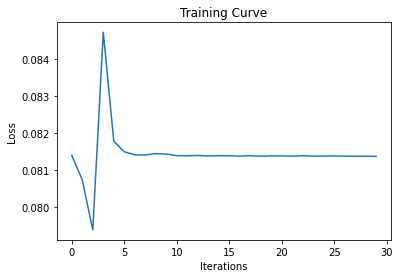

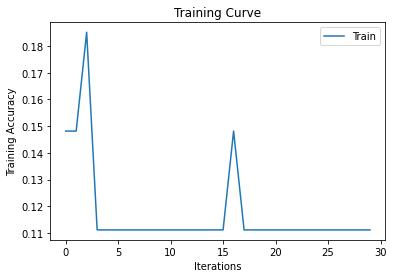

In [51]:
data_path = '/content/drive/My Drive/overfit'
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
overfit_set = torchvision.datasets.ImageFolder(data_path, transform=transform)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1000)
cnn = CNN()
# cnn = cnn.to(device)
if torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Call train function with overfit=True so that we wouldn't use val_set
preds = train_that_cnn(cnn, 27, 0.01, 30, train_set=overfit_set, overfit=True)

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

The three most important hyperparameters can be batch_size, learning rate and number of CNN layers.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

Here we're using the same learning rate as lab 2 with a fairly large batch size. The training accurace we get is and the validation accuraccy is.

In [22]:
torch.manual_seed(100)
cnn = CNN()
if torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_that_cnn(cnn, 300, 0.01, 50)

CUDA is available!  Training on GPU ...


KeyboardInterrupt: ignored

Here we're reducing the learning rate from 0.01 to 0.005 and keeping the batch size the same as before (300). With these settings we get training accuracy of and validation accuracy of.

In [23]:
torch.manual_seed(100)
cnn = CNN()
if torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_that_cnn(cnn, 300, 0.005, 10)

CUDA is available!  Training on GPU ...


KeyboardInterrupt: ignored

Now we can try reducing the batch size to see it's effect. And keep using lr=0.01.

CUDA is not available.  Training on CPU ...
Epoch  1 Accuracy:  0.14676258992805755
Epoch  2 Accuracy:  0.17266187050359713
Epoch  3 Accuracy:  0.1366906474820144
Epoch  4 Accuracy:  0.1366906474820144
Epoch  5 Accuracy:  0.14388489208633093
Epoch  6 Accuracy:  0.17266187050359713
Epoch  7 Accuracy:  0.17266187050359713
Epoch  8 Accuracy:  0.17266187050359713
Epoch  9 Accuracy:  0.1079136690647482
Epoch  10 Accuracy:  0.1079136690647482
Final Training Accuracy: 0.17266187050359713
Final Validation Accuracy: 0.1336206896551724
Total time elapsed: 1020.09 seconds


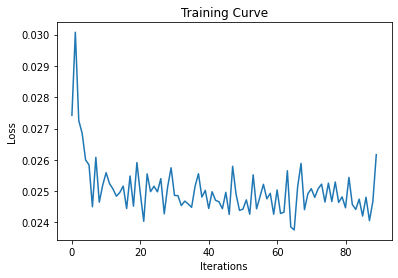

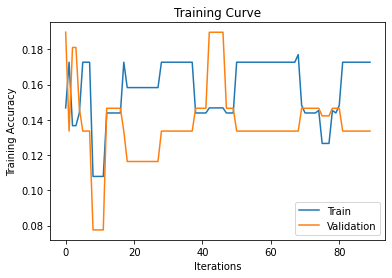

In [ ]:
torch.manual_seed(100)
cnn = CNN()
if torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_that_cnn(cnn, 80, 0.01, 10)

Finally I will add an extra pooling layer to further reduce the output size from 24 to 12.

In [24]:
torch.manual_seed(100)
cnn = CNN()
if torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_that_cnn(cnn, 150, 0.01, 10)

CUDA is available!  Training on GPU ...


KeyboardInterrupt: ignored

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

I would expect the best model would be one with 200-300 batch size (considering the size of our dataset it would be around 5-10 batches), and learning rate of 0.01 and 1000 epochs.
Since as I added more layers as I was testing, I think the current architecture with 3 convolutional layers, 4 pooling layers and 2 fully connected layers is the best.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [74]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.5 MB/s 


In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:

    if torch.cuda.is_available():
      inputs = inputs.cuda()
      labels = labels.cuda()
    output = cnn(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)

from torchmetrics.classification import MulticlassF1Score
metric = MulticlassF1Score(num_classes=9)
metric(torch.tensor(y_pred), torch.tensor(y_true))
# print(metric)

# def get_all_preds(model, loader):
#     all_preds = torch.tensor([])
#     all_labels = torch.tensor([])
#     model.eval() # set model to evaluate mode
    
#     for images, labels in loader:
#         if torch.cuda.is_available():
#           all_preds = all_preds.cuda()
#           all_labels = all_labels.cuda()
#           images = images.cuda()
#           labels = labels.cuda()
#         preds = model(images)
#         # print(labels)
#         all_preds = torch.cat((all_preds, preds), dim=0)
#         print(all_preds)
#         all_labels = torch.cat((all_labels, labels), dim=0)
#         print(all_labels)
    
#     return all_preds, all_labels

# with torch.no_grad(): # disable gradient computations 
#     test_preds, test_labels = get_all_preds(cnn, test_loader)

# stacked = torch.stack((train_set.targets, train_preds.argmax(dim=1)), dim=1)
# confusion_matrix = torch.zeros(10, 10, dtype=torch.int32)
# for row in stacked:
#     true_label, pred_label = row.numpy()
#     confusion_matrix[true_label, pred_label] += 1

# print(confusion_matrix.numpy())
# print(test_preds)
# print(test_labels)
# cm = confusion_matrix(test_labels.cpu(), test_preds.cpu().argmax(dim=1))
# print(cm)

# test_acc, y_predict = get_accuracy(cnn, test_loader)
# test_imgs = []
# test_labels = []
# for imgs, labels in test_loader:
#   test_imgs.append(imgs)
#   test_labels.append(labels)

# res = tf.math.confusion_matrix(tf.Tensor(test_labels, shape=(1,len(test_labels)), dtype=int),tf.Tensor(y_predict, shape=(1, len(y_predict)), dtype=int))

# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(cnn, test_set, test_labels, display_labels=classes, xticks_rotation='vertical')  

# plt.show()
# test_acc = get_accuracy(cnn, test_loader)
# print("test accuracy:", test_acc)

[[ 0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0 25  0  0]
 [ 0  1  0  0  0 42  0  0]
 [ 0  0  0  0  0  2  0  0]]


tensor(0.0218)

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

data_path = '/content/drive/My Drive/AlexFeatures';

# create A-I class folders in the training, validation, and testing folders
def make_that_folder(loader, set_name): 
  n = 0
  for img, label in loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = data_path + '/'+str(set_name)+'/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=1, shuffle=True)

make_that_folder(train_loader, 'training')
make_that_folder(val_loader, 'validation')
make_that_folder(test_loader, 'testing')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# This cnn is much simpler than the one in part 3 which 
# is because we are using AlexNet weights and we won't
# be starting from scratch and won't need much depth.
# I'm using 2 convolutional layers, no pooling, and two
# fully connected layer
class CNNWithAlex(nn.Module):
  def __init__(self):
      self.name = "cnnWithAlex"
      super(CNNWithAlex, self).__init__()
      self.conv1 = nn.Conv2d(256, 64, 3)    # 256 input channels, 64 output channels, 2 kernel size
      self.conv2 = nn.Conv2d(64, 10, 2)     # 64 input channels, 10 output channels, 2 kernel size
      self.fc1 = nn.Linear(10*3*3, 24)      # 160 input features, 24 output fratures
      self.fc2 = nn.Linear(24, 9)           # 24 input features, 9 output fratures

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = x.view(-1, 10*3*3)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = CNNWithAlex(features)
prob = F.softmax(output)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
alex_train_path = '/content/drive/My Drive/AlexFeatures/training'
alex_val_path = '/content/drive/My Drive/AlexFeatures/validation'
alex_test_path = '/content/drive/My Drive/AlexFeatures/testing'

alex_train_set = torchvision.datasets.DatasetFolder(alex_train_path, loader=torch.load, extensions=('.tensor'))
alex_val_set = torchvision.datasets.DatasetFolder(alex_val_path, loader=torch.load, extensions=('.tensor'))
alex_test_set = torchvision.datasets.DatasetFolder(alex_test_path, loader=torch.load, extensions=('.tensor'))

CUDA is not available.  Training on CPU ...
Epoch  1 Accuracy:  0.15251798561151078
Epoch  2 Accuracy:  0.14532374100719425
Epoch  3 Accuracy:  0.19424460431654678
Epoch  4 Accuracy:  0.29784172661870506
Epoch  5 Accuracy:  0.3899280575539568
Epoch  6 Accuracy:  0.4014388489208633
Epoch  7 Accuracy:  0.34820143884892085
Epoch  8 Accuracy:  0.36258992805755397
Epoch  9 Accuracy:  0.376978417266187
Epoch  10 Accuracy:  0.4719424460431655
Epoch  11 Accuracy:  0.45611510791366905
Epoch  12 Accuracy:  0.49928057553956834
Epoch  13 Accuracy:  0.5122302158273381
Epoch  14 Accuracy:  0.5424460431654676
Epoch  15 Accuracy:  0.5841726618705037
Epoch  16 Accuracy:  0.5856115107913669
Epoch  17 Accuracy:  0.6230215827338129
Epoch  18 Accuracy:  0.5971223021582733
Epoch  19 Accuracy:  0.6143884892086331
Epoch  20 Accuracy:  0.7093525179856115
Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8879310344827587
Total time elapsed: 299.37 seconds


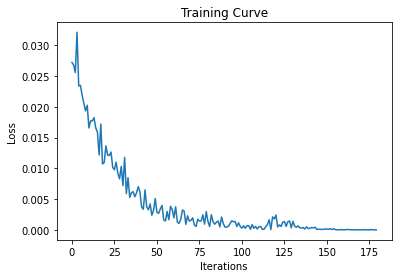

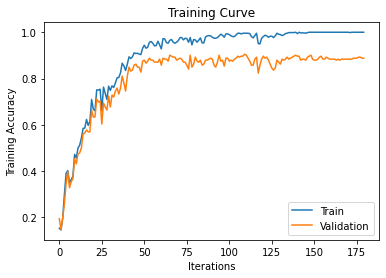

In [ ]:
cnnWithAlex = CNNWithAlex()
if torch.cuda.is_available():
  cnnWithAlex.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_that_cnn(cnnWithAlex, 80, 0.008, 20, alex_train_set, alex_val_set)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
test_loader = torch.utils.data.DataLoader(alex_test_set, batch_size=16, shuffle=True)
test_acc = get_accuracy(cnnWithAlex, test_loader)
print("test accuracy:", test_acc)

test accuracy: 0.8658008658008658


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
data_path = '/content/drive/My Drive/overfit'
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
overfit_set = torchvision.datasets.ImageFolder(data_path, transform=transform)
overfit_test_loader = torch.utils.data.DataLoader(overfit_set, batch_size=27, shuffle=True)
overfit_test_acc = get_accuracy(cnnWithAlex, overfit_test_loader)
print("test accuracy:", overfit_test_acc)

test accuracy: 0.8958008678008754


The model wasn't able to acheive accuracy of 100% unlike our own. It's possible that the current model is too complex for our very small dataset.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab3_Gesture_Recognition.ipynb

[NbConvertApp] Converting notebook /content/Lab3_Gesture_Recognition.ipynb to html
[NbConvertApp] Writing 592799 bytes to /content/Lab3_Gesture_Recognition.html
